# Live Casino Recommendation System — Experimentation Notebook
**Quantum Horizon | Phase 1 — LightFM Hybrid Model**

---

### Notebook Flow
```
CELL 0  → Installs & Imports
CELL 1  → Simulate Data (Games, Users, Transactions)
CELL 2  → EDA (Understand your data before touching the model)
CELL 3  → Feature Engineering (Interaction Matrix + User/Item Features)
CELL 4  → LightFM Training
CELL 5  → Evaluation (Precision@K, AUC)
CELL 6  → Advanced EDA--> User behaviour, sparsity
CELL 7  → Advanced Feature Engineering--> Ablation + Correlation
CELL 8 → Auto Interpretation (Business + Modeling Takeaways)
CELL 9 → Extended Visualization Suite (Series of Plots)
```

In [1]:
print("hello world")

hello world


In [2]:
!python --version

Python 3.10.19


In [3]:
import lightfm

In [4]:
import pandas as pd 
import numpy as np
import random  
import os 
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime, timedelta
from scipy.sparse import coo_matrix
from sklearn.preprocessing import LabelEncoder

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score 

warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print('All imports successful')

All imports successful


---
## CELL 1 — Simulate Data
> Simulates MongoDB collections: games, users, transactions
>
> Replace this entire cell later with real DuckDB → pandas load

In [6]:
#CONFIG 
N_USERS  = 5000
N_DAYS   = 90
TODAY    = datetime.now()

#GAMES
GAME_TYPES = {
    'Baccarat':    {'count': 12, 'min_bet_range': (500,  2000),  'max_bet_range': (50000,  200000)},
    'Roulette':    {'count': 10, 'min_bet_range': (100,  1000),  'max_bet_range': (20000,  100000)},
    'Blackjack':   {'count': 10, 'min_bet_range': (500,  2000),  'max_bet_range': (50000,  150000)},
    'DragonTiger': {'count': 8,  'min_bet_range': (200,  1000),  'max_bet_range': (20000,   80000)},
    'SicBo':       {'count': 6,  'min_bet_range': (200,  1000),  'max_bet_range': (30000,  100000)},
    'Poker':       {'count': 8,  'min_bet_range': (1000, 5000),  'max_bet_range': (100000, 500000)},
    'CrazyTime':   {'count': 4,  'min_bet_range': (100,  500),   'max_bet_range': (10000,   50000)},
    'Monopoly':    {'count': 4,  'min_bet_range': (100,  500),   'max_bet_range': (10000,   50000)},
    'BacBo':       {'count': 4,  'min_bet_range': (500,  2000),  'max_bet_range': (50000,  150000)},
    'AndarBahar':  {'count': 6,  'min_bet_range': (100,  500),   'max_bet_range': (10000,   50000)},
    'TeenPatti':   {'count': 4,  'min_bet_range': (200,  1000),  'max_bet_range': (20000,   80000)},
    'Megaball':    {'count': 4,  'min_bet_range': (100,  500),   'max_bet_range': (10000,   40000)},
}
VENDORS = ['Evolution', 'Pragmatic Play', 'Ezugi', 'Playtech', 'SA Gaming']

games, game_counter = [], 1476000   #games ko store krne k liye ek empty list and starting ID number for these games
for game_type, cfg in GAME_TYPES.items():
    for i in range(cfg['count']):  #creates multiple versions of the game
        min_bet  = random.choice(range(cfg['min_bet_range'][0], cfg['min_bet_range'][1], 100))
        max_bet  = random.choice(range(cfg['max_bet_range'][0], cfg['max_bet_range'][1], 1000))   #will create different min and max bet for each game(more realistic)
        subs     = ['All Games']  
        if i < 3: subs.append('Top Games')
        if i < 5: subs.append('Most Popular')
            
        games.append({
            'gameId':        str(game_counter + i),
            'gameName':      f"{game_type} ({800 + len(games)})",
            'gameType':      game_type,
            'vendor':        random.choice(VENDORS),
            'minBet':        min_bet,
            'maxBet':        max_bet,
            'betRange':      max_bet - min_bet,   #FEATURE ENGINEERED
            'isTopGame':     'Top Games' in subs,
            'isMostPopular': 'Most Popular' in subs,
            'gameStatus':    'ON',
        })
    game_counter += cfg['count']   #INCREASES ID COUNTER FOR THE NEXT GAME

games_df = pd.DataFrame(games)
print(f'✅ Games: {len(games_df)} | Types: {games_df["gameType"].nunique()}')

✅ Games: 80 | Types: 12


In [7]:
#USERS
USER_ARCHETYPES = {
    'high_roller': {'proportion': 0.05, 'sessions_pw': (5,14),  'bet_mult': (5,20),  'preferred': ['Baccarat','Poker','Blackjack'], 'duration': (30,120), 'hours': [19,20,21,22,23]},
    'regular':     {'proportion': 0.25, 'sessions_pw': (2,7),   'bet_mult': (1,5),   'preferred': ['Baccarat','Roulette','DragonTiger','SicBo'], 'duration': (10,45),  'hours': [18,19,20,21,22]},
    'casual':      {'proportion': 0.40, 'sessions_pw': (1,3),   'bet_mult': (1,2),   'preferred': ['CrazyTime','Monopoly','Megaball','AndarBahar'], 'duration': (5,20),   'hours': [12,13,18,19,20,21]},
    'explorer':    {'proportion': 0.20, 'sessions_pw': (2,5),   'bet_mult': (1,3),   'preferred': list(GAME_TYPES.keys()), 'duration': (5,30),   'hours': [10,14,18,20,22]},
    'dormant':     {'proportion': 0.10, 'sessions_pw': (0,1),   'bet_mult': (1,2),   'preferred': ['AndarBahar','TeenPatti'], 'duration': (2,10),   'hours': [20,21]},
}

archetype_list = []
for a, cfg in USER_ARCHETYPES.items():
    archetype_list.extend([a] * int(N_USERS * cfg['proportion']))  #5000 users m se proportinality of the users are being added to the list
    
while len(archetype_list) < N_USERS: 
    archetype_list.append('casual') 
random.shuffle(archetype_list)

users_df = pd.DataFrame([
    {'userId':    f'u_{str(i+1).zfill(5)}',
     'archetype': archetype_list[i],
     'country':   random.choice(['IN','AE','GB','US','SG','MY']),
     'device':    random.choice(['mobile','desktop','tablet']),
     'joinedAt':  (TODAY - timedelta(days=random.randint(1, N_DAYS))).isoformat()}
    for i in range(N_USERS)
])

print(f'✅ Users: {len(users_df)}')
print(users_df['archetype'].value_counts())

✅ Users: 5000
archetype
casual         2000
regular        1250
explorer       1000
dormant         500
high_roller     250
Name: count, dtype: int64


In [8]:
# ── TRANSACTIONS ────────────────────────────────────────
transactions = []

for _, user in users_df.iterrows():
    cfg           = USER_ARCHETYPES[user['archetype']]
    total_sessions = int((N_DAYS / 7) * random.randint(*cfg['sessions_pw']))
    if total_sessions == 0:
        continue

    user_games = games_df[games_df['gameType'].isin(cfg['preferred'])]
    n_unique   = min(random.randint(2, 10 if user['archetype']=='explorer' else 5), len(user_games))
    if n_unique == 0:
        continue

    played_games = user_games.sample(n=n_unique, replace=False)
    weights      = np.random.dirichlet(np.ones(n_unique))

    for idx, (_, game) in enumerate(played_games.iterrows()):
        game_sessions = max(1, int(total_sessions * weights[idx]))
        for _ in range(game_sessions):
            days_ago   = random.randint(0, N_DAYS - 1)
            hour       = random.choice(cfg['hours'])
            ts         = (TODAY - timedelta(days=days_ago, minutes=random.randint(0,59))).replace(hour=hour)
            bet        = int(game['minBet'] * random.uniform(*cfg['bet_mult']))
            bet        = max(game['minBet'], min(bet, game['maxBet']))
            transactions.append({
                'userId':          user['userId'],
                'gameId':          game['gameId'],
                'gameType':        game['gameType'],
                'betAmount':       bet,
                'sessionDuration': random.randint(*cfg['duration']),
                'outcome':         random.choices(['win','loss','break_even'], weights=[0.35,0.55,0.10])[0],
                'timestamp':       ts.isoformat(),
                'hourOfDay':       ts.hour,
                'dayOfWeek':       ts.strftime('%A'),
            })

transactions_df = pd.DataFrame(transactions)
transactions_df['timestamp'] = pd.to_datetime(transactions_df['timestamp'])
print(f'✅ Transactions: {len(transactions_df):,}')
print(f'Unique users with activity: {transactions_df["userId"].nunique():,}')
print(f'Avg transactions/user: {len(transactions_df)/transactions_df["userId"].nunique():.1f}')

✅ Transactions: 194,164
Unique users with activity: 4,766
Avg transactions/user: 40.7


---
## CELL 2 — EDA
> In real project: run this on actual MongoDB data first.

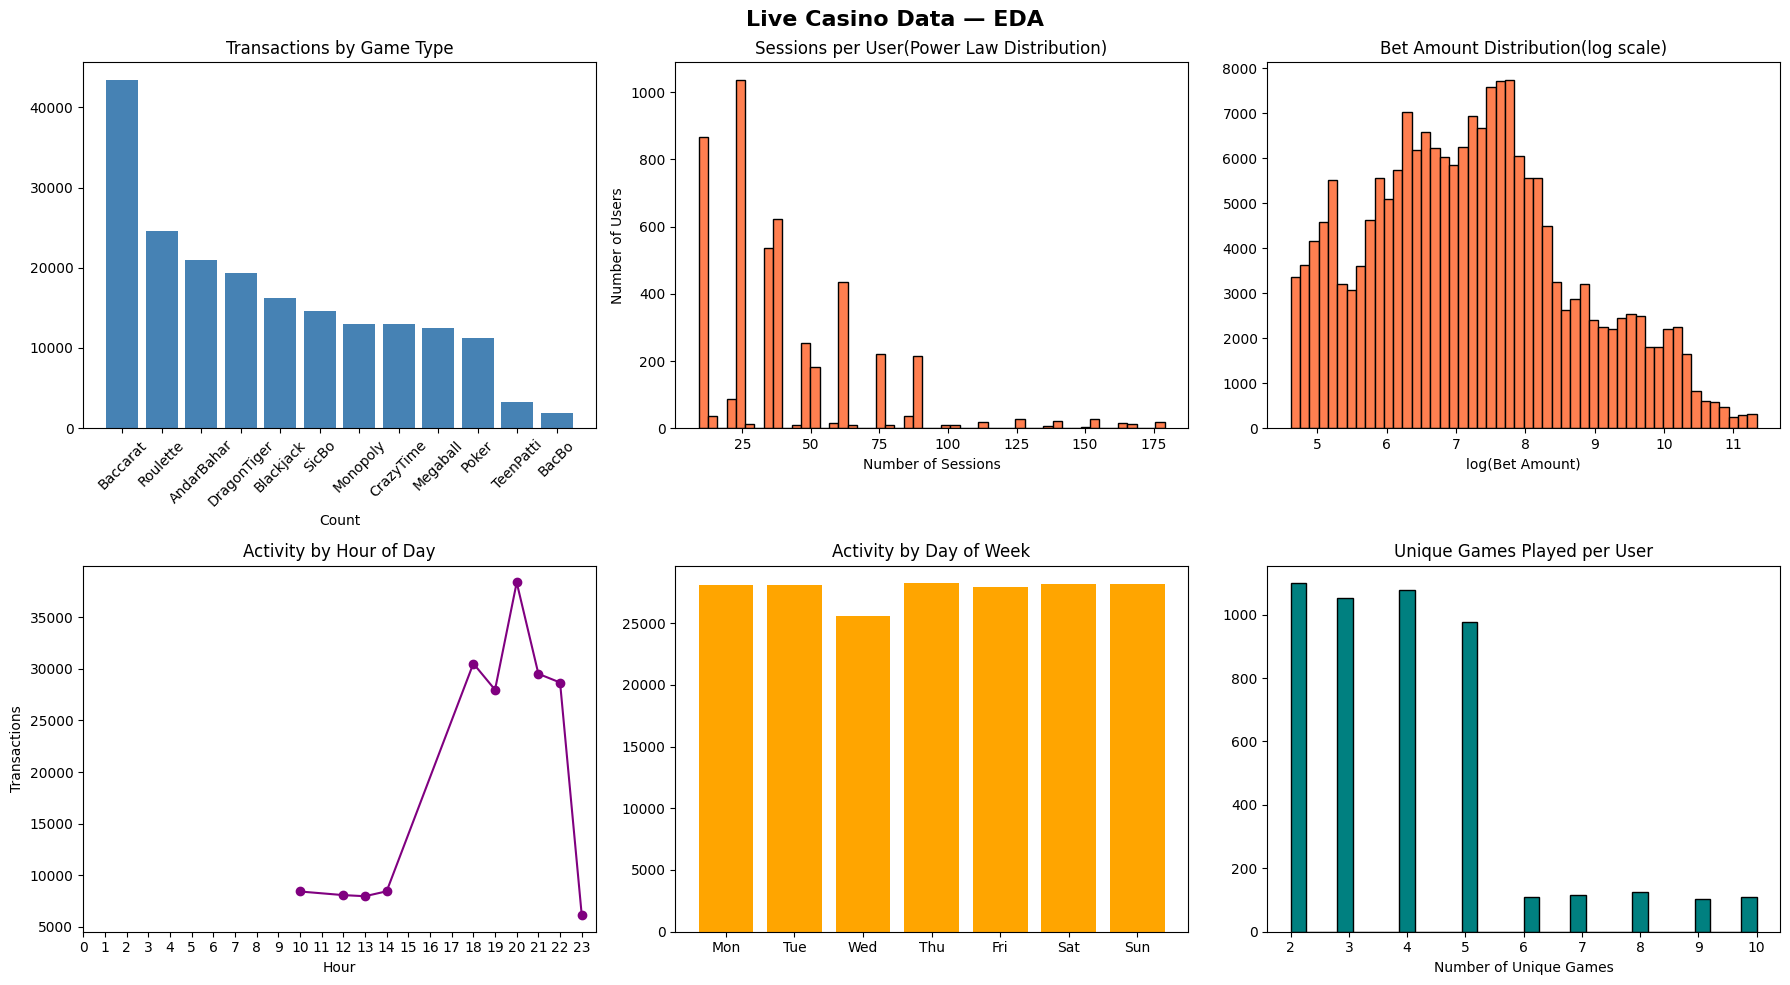


📊 Key Stats:
  Total transactions:         194,164
  Active users (≥1 tx):       4,766
  Median sessions/user:       36
  Avg unique games/user:      4.0
  Interaction matrix density: 4.75%


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Live Casino Data — EDA', fontsize=16, fontweight='bold')

# 1. Transactions per game type
game_type_counts = transactions_df.merge(games_df[['gameId','gameType']], on='gameId', suffixes=('','_g'))['gameType_g'].value_counts() if 'gameType' not in transactions_df.columns else transactions_df['gameType'].value_counts()
axes[0,0].bar(game_type_counts.index, game_type_counts.values, color='steelblue')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_title('Transactions by Game Type')
axes[0,0].set_xlabel('Count')


#2. Sessions per user(power law - should be skewed)
user_session_counts = transactions_df.groupby('userId').size()
axes[0,1].hist(user_session_counts, bins=50, color='coral', edgecolor='black', orientation='vertical')
axes[0,1].set_title('Sessions per User(Power Law Distribution)')
axes[0,1].set_xlabel('Number of Sessions')
axes[0,1].set_ylabel('Number of Users')


#3. Bet amount distribution
axes[0, 2].hist(np.log1p(transactions_df['betAmount']), bins = 50, color = 'coral', edgecolor = 'black')
axes[0, 2].set_title('Bet Amount Distribution(log scale)')
axes[0, 2].set_xlabel('log(Bet Amount)')


# 4. Activity by hour of day
hourly = transactions_df.groupby('hourOfDay').size()
axes[1,0].plot(hourly.index, hourly.values, marker='o', color='purple')
axes[1,0].set_title('Activity by Hour of Day')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Transactions')
axes[1,0].set_xticks(range(0,24))

# 5. Activity by day of week
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily = transactions_df.groupby('dayOfWeek').size().reindex(day_order)
axes[1,1].bar(range(7), daily.values, color='orange', tick_label=[d[:3] for d in day_order])
axes[1,1].set_title('Activity by Day of Week')

# 6. Unique games played per user
unique_games_per_user = transactions_df.groupby('userId')['gameId'].nunique()
axes[1,2].hist(unique_games_per_user, bins=30, color='teal', edgecolor='black')
axes[1,2].set_title('Unique Games Played per User')
axes[1,2].set_xlabel('Number of Unique Games')

plt.tight_layout()
plt.show()

print('\n📊 Key Stats:')
print(f'  Total transactions:         {len(transactions_df):,}')
print(f'  Active users (≥1 tx):       {transactions_df["userId"].nunique():,}')
print(f'  Median sessions/user:       {user_session_counts.median():.0f}')
print(f'  Avg unique games/user:      {unique_games_per_user.mean():.1f}')
print(f'  Interaction matrix density: {len(transactions_df.groupby(["userId","gameId"])) / (N_USERS * len(games_df)) * 100:.2f}%')

---
## CELL 3 — Feature Engineering
> Builds the 3 inputs LightFM needs:
> 1. Interaction matrix (user × game with implicit score)
> 2. User feature matrix
> 3. Item feature matrix

In [10]:
#3A--> Computing implicit score
#creating a 'target' column--> not a single column but a strength of preference(user, game) pair

transactions_df['days_ago'] = (TODAY - transactions_df['timestamp']).dt.days

interaction_agg = transactions_df.groupby(['userId', 'gameId']).agg(
    play_count = ('betAmount', 'count'),
    total_bet = ('betAmount', 'sum'),
    avg_bet = ('betAmount', 'mean'),
    avg_session_min = ('sessionDuration', 'mean'),
    last_played_days_ago = ('days_ago', 'min'),
).reset_index()


def compute_implicit_score(row):
    #recency weight
    d = row['last_played_days_ago']
    recency_w = 1.0 if d <= 7 else (0.7 if d <= 30 else(0.4 if d <= 90 else 0.2))

    freq_score = min(row['play_count']/20.0, 1.0)
    bet_score = min(row['total_bet']/500000.0, 1.0)
    session_score = min(row['avg_session_min']/60.0, 1.0)

    return round(0.35 * freq_score + 0.25 * bet_score + 0.20 * session_score + 0.20 * recency_w, 4)

interaction_agg['implicit_score'] = interaction_agg.apply(compute_implicit_score, axis = 1)

print(f"Interaction pairs: {len(interaction_agg):,}")
print(interaction_agg['implicit_score'].describe().round(3))

Interaction pairs: 19,018
count    19018.000
mean         0.372
std          0.197
min          0.104
25%          0.218
50%          0.325
75%          0.492
max          1.000
Name: implicit_score, dtype: float64


In [11]:
#3B--> User features
user_features_agg = transactions_df.groupby('userId').agg(
    total_sessions = ('betAmount', 'count'),
    avg_bet = ('betAmount', 'mean'),
    total_bet = ('betAmount', 'sum'),
    avg_session_duration = ('sessionDuration', 'mean'),
    unique_games_played = ('gameId', 'nunique'),
    preferred_hour = ('hourOfDay', lambda x: x.mode()[0]),
    preferred_day = ('dayOfWeek', lambda x: x.mode()[0]),
    last_active_days_ago = ('days_ago', 'min'),
    sessions_last_7d = ('days_ago', lambda x: (x <=7).sum()),
    sessions_last_30d = ('days_ago', lambda x: (x <= 30).sum()),
).reset_index()


#preferred game type per user
preferred_game_type = (
    transactions_df.groupby(['userId', 'gameType'])
    .size()
    .reset_index(name = 'count')
    .sort_values('count', ascending = False)
    .groupby('userId')
    .first()
    .reset_index()[['userId', 'gameType']]
    .rename(columns = {'gameType': 'preferred_game_type'})
)

user_features_df = user_features_agg.merge(preferred_game_type, on = 'userId', how = 'left')
user_features_df = user_features_df.merge(users_df[['userId', 'country', 'device']], on = 'userId', how = 'left')

print(f"User features shape: {user_features_df.shape}")
user_features_df.head(3)

User features shape: (4766, 14)


,userId,total_sessions,avg_bet,total_bet,avg_session_duration,unique_games_played,preferred_hour,preferred_day,last_active_days_ago,sessions_last_7d,sessions_last_30d,preferred_game_type,country,device
0,u_00001,37,348.189189,12883,12.810811,3,18,Friday,2,4,14,AndarBahar,SG,tablet
1,u_00002,25,311.120000,7778,11.120000,4,21,Friday,-1,1,9,AndarBahar,SG,mobile
2,u_00003,23,1687.130435,38804,17.000000,9,10,Friday,2,2,9,Roulette,SG,desktop


In [12]:
#3B --> Item features
game_popularity = transactions_df.groupby('gameId').agg(
    total_plays         = ('betAmount',       'count'),
    unique_players      = ('userId',          'nunique'),
    avg_bet_on_game     = ('betAmount',       'mean'),
    avg_session_on_game = ('sessionDuration', 'mean'),
).reset_index()

item_features_df = games_df.merge(game_popularity, on='gameId', how='left').fillna(0)

# Log-normalize popularity (heavy hitters wont dominate)
item_features_df['popularity_score'] = np.log1p(item_features_df['total_plays'])

print(f'✅ Item features shape: {item_features_df.shape}')
item_features_df[['gameId','gameName','gameType','vendor','minBet','maxBet','total_plays','popularity_score']].head(5)

✅ Item features shape: (80, 15)


,gameId,gameName,gameType,vendor,minBet,maxBet,total_plays,popularity_score
0,1476000,Baccarat (800),Baccarat,Evolution,1500,78000,3391,8.129175
1,1476001,Baccarat (801),Baccarat,Pragmatic Play,1600,120000,3403,8.132706
2,1476002,Baccarat (802),Baccarat,Evolution,800,85000,3702,8.216899
3,1476003,Baccarat (803),Baccarat,Evolution,1500,189000,4000,8.294300
4,1476004,Baccarat (804),Baccarat,Evolution,1400,158000,3174,8.063063


---
## CELL 4 — LightFM Training
> Uses LightFM's `Dataset` class to properly encode users, items, and features
>
> **Loss = WARP** → Best for implicit feedback ranking problems

In [13]:
#building LightFM dataset

dataset = Dataset()

#telling lightfm about all possible users and items
dataset.fit(
    users = interaction_agg['userId'].unique(),
    items = interaction_agg['gameId'].unique(),

    #item features lightFM will use for content based filtering
    item_features = (
        [f'gameType:{t}' for t in item_features_df['gameType'].unique()] +
        [f'vendor:{v}'   for v in item_features_df['vendor'].unique()]   +
        ['isTopGame:True', 'isTopGame:False',
         'isMostPopular:True', 'isMostPopular:False']
    ),



    #game features lightFM will use for content based filtering
    user_features = (
        [f'preferred_game_type:{t}' for t in user_features_df['preferred_game_type'].dropna().unique()] +
        [f'country:{c}'             for c in user_features_df['country'].dropna().unique()]             +
        [f'device:{d}'              for d in user_features_df['device'].dropna().unique()]
    ),
)

print("LightFM dataset built")
n_users, n_items = dataset.interactions_shape()
print(f"Users: {n_users}, Games: {n_items}")

LightFM dataset built
Users: 4766, Games: 80


In [14]:
#building interaction matrix
(interactions, weights) = dataset.build_interactions(
    (
        (row['userId'], row['gameId'], row['implicit_score'])
        for _, row in interaction_agg.iterrows()
    )
)

print(f"Interaction Matrix: {interactions.shape}")
print(f"Non-Zero entries: {interactions.nnz:,}")
print(f"Matrix density: {interactions.nnz / (interactions.shape[0]*interactions.shape[1]) * 100: .3f}%")

Interaction Matrix: (4766, 80)
Non-Zero entries: 19,018
Matrix density:  4.988%


In [15]:
#building item feature matrix
def get_item_features_list(row):
    return [
        f'gameType:{row["gameType"]}',
        f'vendor:{row["vendor"]}',
        f'isTopGame:{row["isTopGame"]}',
        f'isMostPopular:{row["isMostPopular"]}',
    ]

item_features_matrix = dataset.build_item_features(
    (
        (row['gameId'], get_item_features_list(row))
        for _, row in item_features_df.iterrows()
        if row['gameId'] in interaction_agg['gameId'].values  # only games with interactions
    )
)

print(f'✅ Item feature matrix: {item_features_matrix.shape}')

✅ Item feature matrix: (80, 101)


In [16]:
# ── STEP 4D: Build User Feature Matrix ──────────────────
def get_user_features_list(row):
    feats = [f'device:{row["device"]}']
    if pd.notna(row['country']):
        feats.append(f'country:{row["country"]}')
    if pd.notna(row['preferred_game_type']):
        feats.append(f'preferred_game_type:{row["preferred_game_type"]}')
    return feats

active_user_ids = set(interaction_agg['userId'].unique())

user_features_matrix = dataset.build_user_features(
    (
        (row['userId'], get_user_features_list(row))
        for _, row in user_features_df.iterrows()
        if row['userId'] in active_user_ids
    )
)

print(f'✅ User feature matrix: {user_features_matrix.shape}')

✅ User feature matrix: (4766, 4787)


In [17]:
#Train test split--> Temporal split rahega and not random to avoid data leakage
from lightfm.cross_validation import random_train_test_split

# NOTE: In real project, do temporal split manually:
#   train = interactions before cutoff_date
#   test  = interactions after cutoff_date
# For now using LightFM's random split as a quick baseline

train_interactions, test_interactions = random_train_test_split(
    interactions,
    random_state = SEED,
    test_percentage = 0.15
)

print(f"Train Interactions: {train_interactions.nnz:,}")
print(f"Test Interactions: {test_interactions.nnz:,}")

Train Interactions: 16,165
Test Interactions: 2,853


In [18]:
print(interactions.shape)
print(user_features_matrix.shape)
print(item_features_matrix.shape)

(4766, 80)
(4766, 4787)
(80, 101)


In [20]:
#TRAINING OUR MODEL
model = LightFM(
    no_components = 64,
    loss = 'warp',
    learning_rate = 0.05,
    item_alpha = 1e-6,  #L2 reg on item features
    user_alpha = 1e-6,  #L2 reg on user features
    random_state = SEED,
)

N_EPOCHS = 30
print(f'Training LightFM for {N_EPOCHS} epochs')


train_precision, test_precision = [], []

for epoch in range(N_EPOCHS):
    model.fit_partial(
        interactions = train_interactions,
        user_features = user_features_matrix,
        item_features = item_features_matrix,
        num_threads = 4,
        epochs = 1,
    )

Training LightFM for 30 epochs


In [21]:
# Evaluate every 5 epochs
if (epoch + 1) % 5 == 0:
    train_p = precision_at_k(
        model, train_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        k=10, num_threads=4
    ).mean()
    test_p = precision_at_k(
        model, test_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        k=10, num_threads=4
    ).mean()
    train_precision.append(train_p)
    test_precision.append(test_p)
    print(f'  Epoch {epoch+1:2d}/{N_EPOCHS} | Train P@10: {train_p:.4f} | Test P@10: {test_p:.4f}')

print('\n✅ Training complete')

  Epoch 30/30 | Train P@10: 0.2195 | Test P@10: 0.0608

✅ Training complete


---
## CELL 5 — Evaluation

  EVALUATION RESULTS
  Train Precision@10:  0.2195
  Test  Precision@10:  0.0608
  Train AUC:           0.9078
  Test  AUC:           0.7866
⚠️  Possible overfitting — consider increasing regularization (item_alpha, user_alpha)


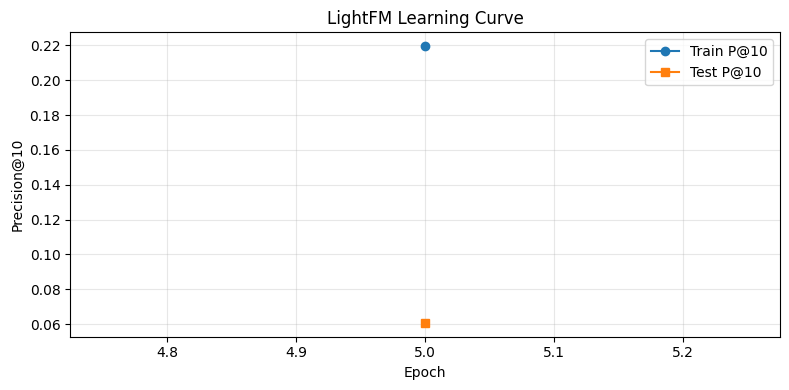

In [22]:
# ── Precision@K and AUC ──────────────────────────────────
final_train_precision = precision_at_k(
    model, train_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    k=10, num_threads=4
).mean()

final_test_precision = precision_at_k(
    model, test_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    k=10, num_threads=4
).mean()

train_auc = auc_score(
    model, train_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    num_threads=4
).mean()

test_auc = auc_score(
    model, test_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    num_threads=4
).mean()

print('=' * 40)
print('  EVALUATION RESULTS')
print('=' * 40)
print(f'  Train Precision@10:  {final_train_precision:.4f}')
print(f'  Test  Precision@10:  {final_test_precision:.4f}')
print(f'  Train AUC:           {train_auc:.4f}')
print(f'  Test  AUC:           {test_auc:.4f}')
print('=' * 40)

if final_train_precision - final_test_precision > 0.1:
    print('⚠️  Possible overfitting — consider increasing regularization (item_alpha, user_alpha)')

# Plot learning curve
plt.figure(figsize=(8, 4))
epochs_evaluated = [5, 10, 15, 20, 25, 30]
plt.plot(epochs_evaluated[:len(train_precision)], train_precision, label='Train P@10', marker='o')
plt.plot(epochs_evaluated[:len(test_precision)],  test_precision,  label='Test P@10',  marker='s')
plt.xlabel('Epoch')
plt.ylabel('Precision@10')
plt.title('LightFM Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Filhaal toh model overfit kr raha h but not our current priority since data toh dummy hai, 

eventually real data ayega toh bas usko replace krna rahega and some additional fine-tuning&feature engineering based on the real data
Overall structure of the notebook would be SOMEWHAT this

---
## CELL 6 — Advanced EDA (Behavior, Sparsity, Concentration)
> Deeper diagnostics to understand user behavior, catalog concentration, and matrix sparsity.

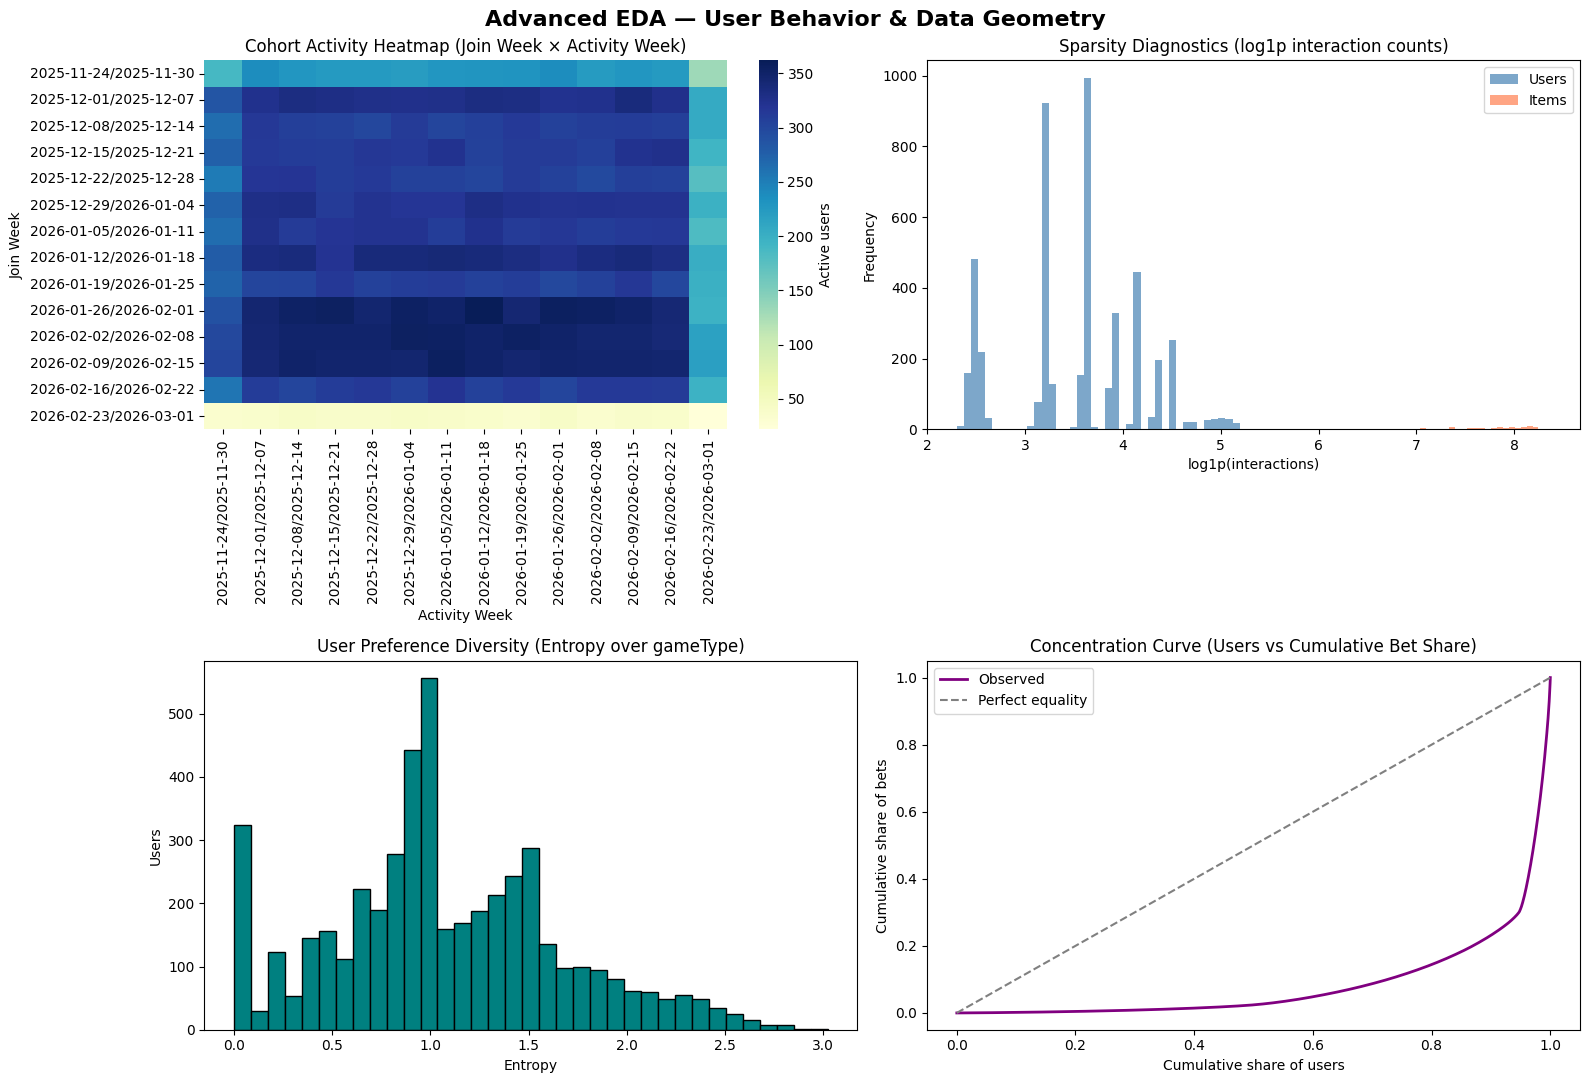

📌 Advanced EDA summary
  Active users: 4,766
  Active items: 80
  Interaction density (active space): 4.99%
  Median user entropy: 0.994


In [23]:
# Advanced EDA
# Assumes: transactions_df, users_df, games_df, interaction_agg are available

# 1) User activity cohorts (join week vs activity week)
cohort_df = transactions_df[['userId', 'timestamp']].copy()
cohort_df = cohort_df.merge(users_df[['userId', 'joinedAt']], on='userId', how='left')
cohort_df['joinedAt'] = pd.to_datetime(cohort_df['joinedAt'])

cohort_df['cohort_week'] = cohort_df['joinedAt'].dt.to_period('W').astype(str)
cohort_df['activity_week'] = cohort_df['timestamp'].dt.to_period('W').astype(str)

cohort_pivot = (
    cohort_df.groupby(['cohort_week', 'activity_week'])['userId']
    .nunique()
    .reset_index(name='active_users')
    .pivot(index='cohort_week', columns='activity_week', values='active_users')
    .fillna(0)
)

# 2) Sparsity diagnostics
user_interactions = transactions_df.groupby('userId').size()
item_interactions = transactions_df.groupby('gameId').size()

# 3) Preference diversity (entropy over gameType)
gt_counts = transactions_df.groupby(['userId', 'gameType']).size().rename('n').reset_index()
user_totals = gt_counts.groupby('userId')['n'].sum().rename('total').reset_index()
entropy_df = gt_counts.merge(user_totals, on='userId', how='left')
entropy_df['p'] = entropy_df['n'] / entropy_df['total']
user_entropy = entropy_df.groupby('userId')['p'].apply(lambda x: -(x * np.log2(x + 1e-12)).sum())

# 4) Concentration (Lorenz-style cumulative share of bets)
user_bets = transactions_df.groupby('userId')['betAmount'].sum().sort_values().values
cum_users = np.arange(1, len(user_bets) + 1) / len(user_bets)
cum_bets = np.cumsum(user_bets) / np.sum(user_bets)

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Advanced EDA — User Behavior & Data Geometry', fontsize=16, fontweight='bold')

sns.heatmap(cohort_pivot, cmap='YlGnBu', ax=axes[0, 0], cbar_kws={'label': 'Active users'})
axes[0, 0].set_title('Cohort Activity Heatmap (Join Week × Activity Week)')
axes[0, 0].set_xlabel('Activity Week')
axes[0, 0].set_ylabel('Join Week')

axes[0, 1].hist(np.log1p(user_interactions), bins=40, alpha=0.7, label='Users', color='steelblue')
axes[0, 1].hist(np.log1p(item_interactions), bins=40, alpha=0.7, label='Items', color='coral')
axes[0, 1].set_title('Sparsity Diagnostics (log1p interaction counts)')
axes[0, 1].set_xlabel('log1p(interactions)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[1, 0].hist(user_entropy, bins=35, color='teal', edgecolor='black')
axes[1, 0].set_title('User Preference Diversity (Entropy over gameType)')
axes[1, 0].set_xlabel('Entropy')
axes[1, 0].set_ylabel('Users')

axes[1, 1].plot(cum_users, cum_bets, label='Observed', color='purple', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], '--', color='gray', label='Perfect equality')
axes[1, 1].set_title('Concentration Curve (Users vs Cumulative Bet Share)')
axes[1, 1].set_xlabel('Cumulative share of users')
axes[1, 1].set_ylabel('Cumulative share of bets')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

interaction_density = len(interaction_agg) / (transactions_df['userId'].nunique() * transactions_df['gameId'].nunique())
print('📌 Advanced EDA summary')
print(f'  Active users: {transactions_df["userId"].nunique():,}')
print(f'  Active items: {transactions_df["gameId"].nunique():,}')
print(f'  Interaction density (active space): {interaction_density * 100:.2f}%')
print(f'  Median user entropy: {user_entropy.median():.3f}')

---
## CELL 7 — Feature Engineering Impact (Ablation + Correlation)
> Adds richer user/item features, runs feature-group ablation, and visualizes directional correlation with model scores.

📌 Feature-group ablation results


,variant,test_precision@10,test_auc,delta_vs_full_p10
4,drop_item_popularity,0.061762,0.791426,0.004950
2,drop_user_behavior,0.057902,0.788271,0.001090
0,full,0.056812,0.784645,0.000000
3,drop_item_metadata,0.049591,0.772815,-0.007221
1,drop_user_context,0.042325,0.726598,-0.014487


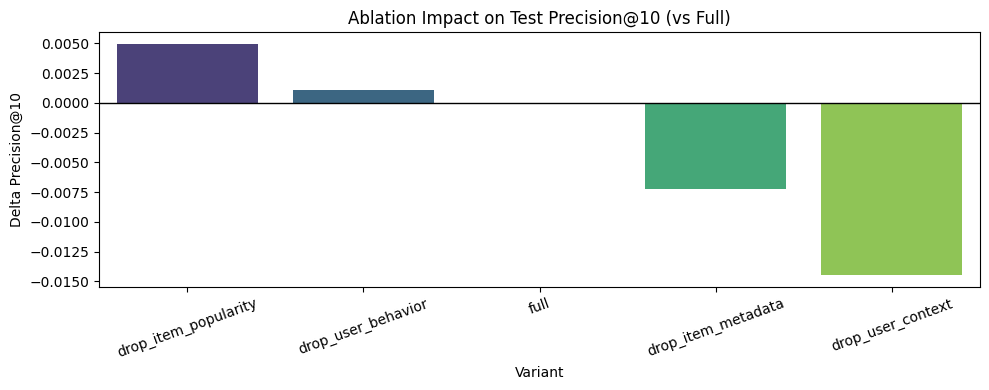

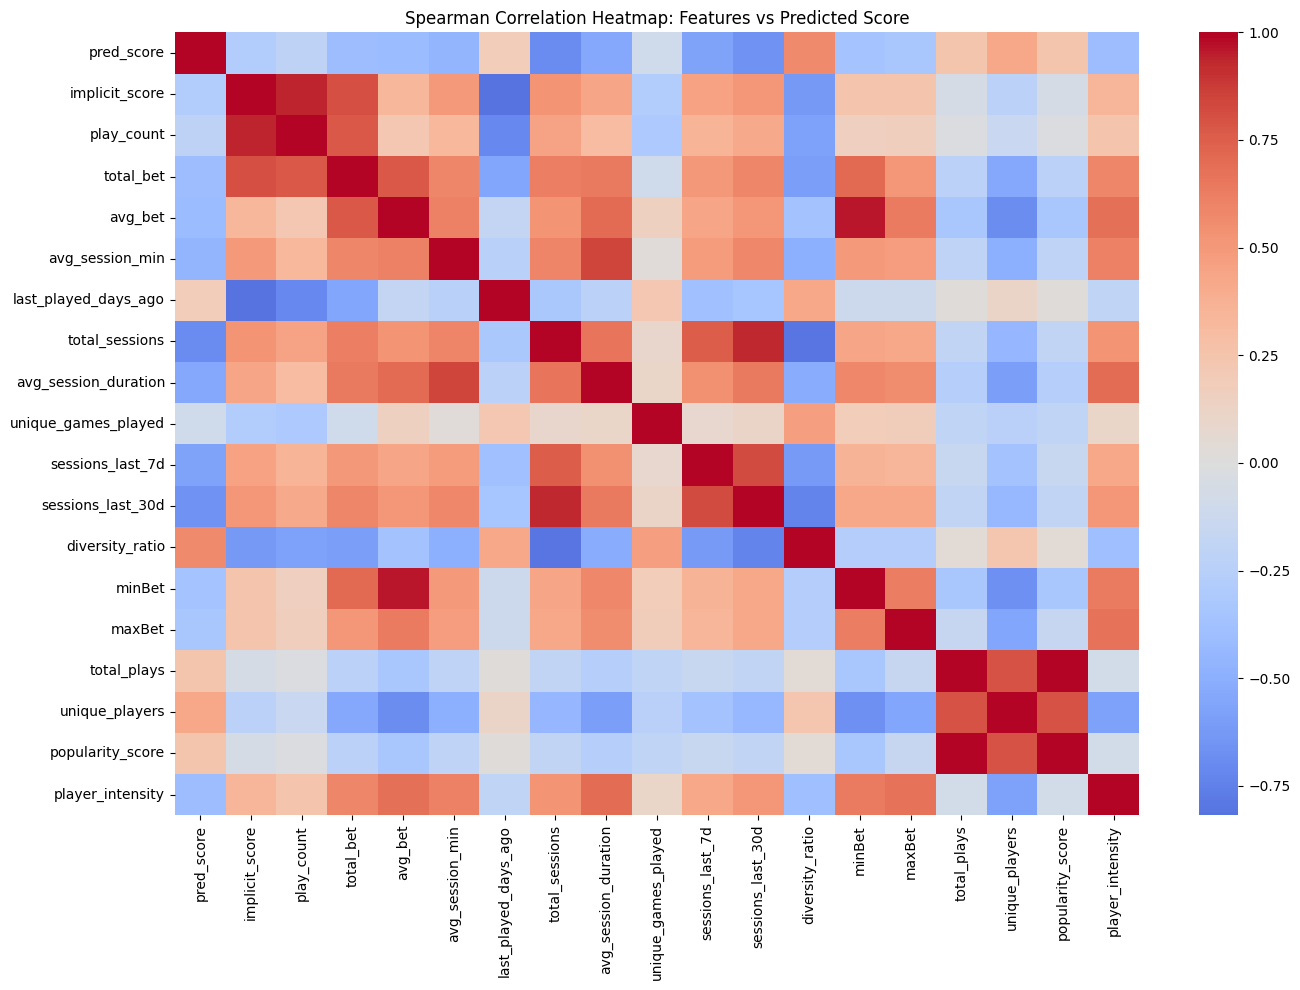

📌 Top direct effects (positive association with model score)


,feature,spearman_with_pred_score,direction
0,diversity_ratio,0.572228,direct (+)
1,unique_players,0.423768,direct (+)
2,popularity_score,0.242466,direct (+)
3,total_plays,0.242466,direct (+)
4,last_played_days_ago,0.184645,direct (+)
5,unique_games_played,-0.097323,inverse (-)
6,play_count,-0.207319,inverse (-)
7,implicit_score,-0.283935,inverse (-)


📌 Top inverse effects (negative association with model score)


,feature,spearman_with_pred_score,direction
17,total_sessions,-0.691135,inverse (-)
16,sessions_last_30d,-0.659659,inverse (-)
15,sessions_last_7d,-0.574034,inverse (-)
14,avg_session_duration,-0.539086,inverse (-)
13,avg_session_min,-0.461055,inverse (-)
12,avg_bet,-0.419066,inverse (-)
11,player_intensity,-0.413035,inverse (-)
10,total_bet,-0.408018,inverse (-)


Note: Correlation here is directional association, not causal effect.


In [25]:
# Feature engineering extensions + impact analysis
# This cell is intentionally self-contained and can be run after previous training blocks.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, auc_score

required_vars = ['interaction_agg', 'user_features_df', 'item_features_df', 'SEED']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise ValueError(f"Missing required variables: {missing}. Run previous feature/training cells first.")

# ------------------------------------------------------------------
# A) Add richer engineered features (user + item)
# ------------------------------------------------------------------
ufe = user_features_df.copy()
ife = item_features_df.copy()

# user-side engineered features
ufe['bet_cv'] = (ufe['avg_bet'] / (ufe['total_bet'] / np.maximum(ufe['total_sessions'], 1))).replace([np.inf, -np.inf], np.nan).fillna(0)
ufe['recency_bucket'] = pd.cut(
    ufe['last_active_days_ago'],
    bins=[-1, 1, 7, 30, 90, 9999],
    labels=['d0_1', 'd2_7', 'd8_30', 'd31_90', 'd90_plus']
).astype(str)
ufe['engagement_bucket'] = pd.qcut(
    ufe['total_sessions'].rank(method='first'),
    q=4,
    labels=['low', 'mid_low', 'mid_high', 'high']
).astype(str)
ufe['diversity_ratio'] = (ufe['unique_games_played'] / np.maximum(ufe['total_sessions'], 1)).clip(0, 1)
ufe['diversity_bucket'] = pd.cut(
    ufe['diversity_ratio'],
    bins=[-0.01, 0.2, 0.5, 0.8, 1.0],
    labels=['very_low', 'low', 'medium', 'high']
).astype(str)

# item-side engineered features
ife['bet_tier'] = pd.qcut(
    ife['minBet'].rank(method='first'),
    q=4,
    labels=['tier1', 'tier2', 'tier3', 'tier4']
).astype(str)
ife['popularity_bucket'] = pd.qcut(
    ife['popularity_score'].rank(method='first'),
    q=4,
    labels=['cold', 'warm', 'hot', 'blockbuster']
).astype(str)
ife['player_intensity'] = (ife['total_plays'] / np.maximum(ife['unique_players'], 1)).fillna(0)

# ------------------------------------------------------------------
# B) Build feature tokens by group
# ------------------------------------------------------------------
def user_tokens(row, groups):
    feats = []
    if 'device' in groups and pd.notna(row.get('device')):
        feats.append(f"device:{row['device']}")
    if 'country' in groups and pd.notna(row.get('country')):
        feats.append(f"country:{row['country']}")
    if 'preferred_game_type' in groups and pd.notna(row.get('preferred_game_type')):
        feats.append(f"preferred_game_type:{row['preferred_game_type']}")
    if 'engagement_bucket' in groups:
        feats.append(f"engagement_bucket:{row['engagement_bucket']}")
    if 'recency_bucket' in groups:
        feats.append(f"recency_bucket:{row['recency_bucket']}")
    if 'diversity_bucket' in groups:
        feats.append(f"diversity_bucket:{row['diversity_bucket']}")
    return feats


def item_tokens(row, groups):
    feats = []
    if 'gameType' in groups and pd.notna(row.get('gameType')):
        feats.append(f"gameType:{row['gameType']}")
    if 'vendor' in groups and pd.notna(row.get('vendor')):
        feats.append(f"vendor:{row['vendor']}")
    if 'top_pop_flags' in groups:
        feats.append(f"isTopGame:{row['isTopGame']}")
        feats.append(f"isMostPopular:{row['isMostPopular']}")
    if 'bet_tier' in groups:
        feats.append(f"bet_tier:{row['bet_tier']}")
    if 'popularity_bucket' in groups:
        feats.append(f"popularity_bucket:{row['popularity_bucket']}")
    return feats


def token_vocab(df, token_func, groups):
    vocab = set()
    for _, r in df.iterrows():
        vocab.update(token_func(r, groups))
    return sorted(vocab)


active_users = interaction_agg['userId'].unique()
active_items = interaction_agg['gameId'].unique()

ufe_active = ufe[ufe['userId'].isin(active_users)].copy()
ife_active = ife[ife['gameId'].isin(active_items)].copy()

# ------------------------------------------------------------------
# C) Ablation runner
# ------------------------------------------------------------------
def run_variant(user_groups, item_groups, epochs=8, components=32):
    ds = Dataset()

    u_vocab = token_vocab(ufe_active, user_tokens, user_groups)
    i_vocab = token_vocab(ife_active, item_tokens, item_groups)

    ds.fit(
        users=active_users,
        items=active_items,
        user_features=u_vocab,
        item_features=i_vocab,
    )

    inter, _ = ds.build_interactions(
        (row['userId'], row['gameId'], row['implicit_score'])
        for _, row in interaction_agg.iterrows()
    )

    train_i, test_i = random_train_test_split(inter, random_state=SEED, test_percentage=0.15)

    ufm = ds.build_user_features(
        (row['userId'], user_tokens(row, user_groups))
        for _, row in ufe_active.iterrows()
    )
    ifm = ds.build_item_features(
        (row['gameId'], item_tokens(row, item_groups))
        for _, row in ife_active.iterrows()
    )

    m = LightFM(
        no_components=components,
        loss='warp',
        learning_rate=0.05,
        item_alpha=1e-6,
        user_alpha=1e-6,
        random_state=SEED,
    )
    m.fit(
        train_i,
        user_features=ufm,
        item_features=ifm,
        epochs=epochs,
        num_threads=4,
        verbose=False,
    )

    p10 = precision_at_k(m, test_i, user_features=ufm, item_features=ifm, k=10, num_threads=4).mean()
    auc = auc_score(m, test_i, user_features=ufm, item_features=ifm, num_threads=4).mean()

    return {
        'model': m,
        'dataset': ds,
        'test_precision@10': float(p10),
        'test_auc': float(auc),
        'user_features_matrix': ufm,
        'item_features_matrix': ifm,
    }


USER_GROUPS_ALL = ['device', 'country', 'preferred_game_type', 'engagement_bucket', 'recency_bucket', 'diversity_bucket']
ITEM_GROUPS_ALL = ['gameType', 'vendor', 'top_pop_flags', 'bet_tier', 'popularity_bucket']

variants = [
    ('full', USER_GROUPS_ALL, ITEM_GROUPS_ALL),
    ('drop_user_context', ['engagement_bucket', 'recency_bucket', 'diversity_bucket'], ITEM_GROUPS_ALL),
    ('drop_user_behavior', ['device', 'country', 'preferred_game_type'], ITEM_GROUPS_ALL),
    ('drop_item_metadata', USER_GROUPS_ALL, ['top_pop_flags', 'bet_tier', 'popularity_bucket']),
    ('drop_item_popularity', USER_GROUPS_ALL, ['gameType', 'vendor']),
]

ablation_rows = []
variant_artifacts = {}

for name, ug, ig in variants:
    out = run_variant(ug, ig)
    variant_artifacts[name] = out
    ablation_rows.append({
        'variant': name,
        'test_precision@10': out['test_precision@10'],
        'test_auc': out['test_auc'],
    })

ablation_df = pd.DataFrame(ablation_rows).sort_values('test_precision@10', ascending=False)
baseline_p10 = ablation_df.loc[ablation_df['variant'] == 'full', 'test_precision@10'].iloc[0]
ablation_df['delta_vs_full_p10'] = ablation_df['test_precision@10'] - baseline_p10

print('📌 Feature-group ablation results')
display(ablation_df)

plt.figure(figsize=(10, 4))
sns.barplot(data=ablation_df, x='variant', y='delta_vs_full_p10', palette='viridis')
plt.axhline(0, color='black', linewidth=1)
plt.title('Ablation Impact on Test Precision@10 (vs Full)')
plt.ylabel('Delta Precision@10')
plt.xlabel('Variant')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# D) Directional correlation with model scores (using FULL variant)
# ------------------------------------------------------------------
full_art = variant_artifacts['full']
full_model = full_art['model']
full_ds = full_art['dataset']
full_ufm = full_art['user_features_matrix']
full_ifm = full_art['item_features_matrix']

user_id_map, user_feat_map, item_id_map, item_feat_map = full_ds.mapping()

corr_df = interaction_agg[['userId', 'gameId', 'implicit_score', 'play_count', 'total_bet', 'avg_bet', 'avg_session_min', 'last_played_days_ago']].copy()
corr_df = corr_df.merge(
    ufe[['userId', 'total_sessions', 'avg_session_duration', 'unique_games_played', 'sessions_last_7d', 'sessions_last_30d', 'diversity_ratio']],
    on='userId',
    how='left'
)
corr_df = corr_df.merge(
    ife[['gameId', 'minBet', 'maxBet', 'total_plays', 'unique_players', 'popularity_score', 'player_intensity']],
    on='gameId',
    how='left'
)

corr_df = corr_df[corr_df['userId'].isin(user_id_map) & corr_df['gameId'].isin(item_id_map)].copy()
corr_df['u_idx'] = corr_df['userId'].map(user_id_map)
corr_df['i_idx'] = corr_df['gameId'].map(item_id_map)

corr_df['pred_score'] = full_model.predict(
    corr_df['u_idx'].values,
    corr_df['i_idx'].values,
    user_features=full_ufm,
    item_features=full_ifm,
    num_threads=4,
)

numeric_cols = [
    'pred_score', 'implicit_score', 'play_count', 'total_bet', 'avg_bet', 'avg_session_min',
    'last_played_days_ago', 'total_sessions', 'avg_session_duration', 'unique_games_played',
    'sessions_last_7d', 'sessions_last_30d', 'diversity_ratio', 'minBet', 'maxBet',
    'total_plays', 'unique_players', 'popularity_score', 'player_intensity'
]

corr_mat = corr_df[numeric_cols].corr(method='spearman')

plt.figure(figsize=(14, 10))
sns.heatmap(corr_mat, cmap='coolwarm', center=0, annot=False)
plt.title('Spearman Correlation Heatmap: Features vs Predicted Score')
plt.tight_layout()
plt.show()

effect_on_score = corr_mat['pred_score'].drop('pred_score').sort_values(ascending=False)
summary = pd.DataFrame({
    'feature': effect_on_score.index,
    'spearman_with_pred_score': effect_on_score.values,
    'direction': np.where(effect_on_score.values >= 0, 'direct (+)', 'inverse (-)')
})

print('📌 Top direct effects (positive association with model score)')
display(summary.head(8))
print('📌 Top inverse effects (negative association with model score)')
display(summary.tail(8).sort_values('spearman_with_pred_score'))

print('Note: Correlation here is directional association, not causal effect.')

---
## CELL 8 — Auto Interpretation (Business + Modeling Takeaways)
> Converts ablation and correlation outputs into plain-English insights, direct/inverse drivers, and next actions.

In [ ]:
# Auto-interpretation of feature impact outputs
# Expects `ablation_df` and `corr_mat` from Cell 31.

if 'ablation_df' not in globals() or 'corr_mat' not in globals():
    print('Please run Cell 31 first (Feature Engineering Impact) so `ablation_df` and `corr_mat` are available.')
else:
    ab = ablation_df.copy()

    # ---------- Ablation interpretation ----------
    if 'delta_vs_full_p10' not in ab.columns:
        baseline_p10 = ab.loc[ab['variant'] == 'full', 'test_precision@10'].iloc[0] if (ab['variant'] == 'full').any() else ab['test_precision@10'].max()
        ab['delta_vs_full_p10'] = ab['test_precision@10'] - baseline_p10

    ab_sorted = ab.sort_values('delta_vs_full_p10')
    hurtful = ab_sorted[ab_sorted['delta_vs_full_p10'] > 0.0].copy()
    helpful = ab_sorted[ab_sorted['delta_vs_full_p10'] < 0.0].copy()

    print('================ INTERPRETATION SUMMARY ================')
    print('\nA) Feature-group impact from ablation')

    if len(helpful) > 0:
        print('  Most useful groups (dropping them hurts P@10):')
        for _, r in helpful.head(3).iterrows():
            print(f"   - {r['variant']}: ΔP@10 = {r['delta_vs_full_p10']:.4f}")
    else:
        print('  No group showed clear positive contribution under current setup.')

    if len(hurtful) > 0:
        print('  Potentially noisy groups (dropping them improves P@10):')
        for _, r in hurtful.sort_values('delta_vs_full_p10', ascending=False).head(3).iterrows():
            print(f"   - {r['variant']}: ΔP@10 = +{r['delta_vs_full_p10']:.4f}")
    else:
        print('  No group looked harmful (good sign).')

    best = ab.sort_values('test_precision@10', ascending=False).iloc[0]
    print(f"\n  Best variant by P@10: {best['variant']} (P@10={best['test_precision@10']:.4f}, AUC={best['test_auc']:.4f})")

    # ---------- Correlation interpretation ----------
    print('\nB) Directional association with model score (Spearman)')

    score_col = 'pred_score'
    if score_col not in corr_mat.columns:
        print('  `pred_score` not found in correlation matrix. Re-run Cell 31.')
    else:
        s = corr_mat[score_col].drop(score_col, errors='ignore').dropna().sort_values(ascending=False)

        top_pos = s.head(5)
        top_neg = s.tail(5)

        print('  Top direct (+) associations:')
        for feat, val in top_pos.items():
            print(f'   - {feat}: {val:.3f}')

        print('  Top inverse (-) associations:')
        for feat, val in top_neg.items():
            print(f'   - {feat}: {val:.3f}')

    # ---------- Actionable next steps ----------
    print('\nC) Recommended next steps')
    print('  1. ')
    print('  2. ')
    print('  3. ')
    print('  4. ')
    print('  5. ')

    print()

================ INTERPRETATION SUMMARY ================

A) Feature-group impact from ablation
  Most useful groups (dropping them hurts P@10):
   - drop_user_context: ΔP@10 = -0.0145
   - drop_item_metadata: ΔP@10 = -0.0072
  Potentially noisy groups (dropping them improves P@10):
   - drop_item_popularity: ΔP@10 = +0.0050
   - drop_user_behavior: ΔP@10 = +0.0011

  Best variant by P@10: drop_item_popularity (P@10=0.0618, AUC=0.7914)

B) Directional association with model score (Spearman)
  Top direct (+) associations:
   - diversity_ratio: 0.572
   - unique_players: 0.424
   - popularity_score: 0.242
   - total_plays: 0.242
   - last_played_days_ago: 0.185
  Top inverse (-) associations:
   - avg_session_min: -0.461
   - avg_session_duration: -0.539
   - sessions_last_7d: -0.574
   - sessions_last_30d: -0.660
   - total_sessions: -0.691

C) Recommended next steps
  1. Keep groups with clearly negative ΔP@10 when dropped (they are helping).
  2. Prune or regularize groups that show p

Actionable Next Steps for Dev/Prod

1. Keep groups with clearly negative ΔP@10 when dropped (they are helping).
2. Prune or regularize groups that show positive ΔP@10 when dropped (possible noise).
3. Validate stability with 3 random seeds before finalizing feature set.
4. Switch to temporal split for production-like offline evaluation.
5. Track segment metrics (new users, high-rollers, dormant) not only global P@10/AUC.

*Note: Correlation indicates direction/association, not causality.*

---
## CELL 9 — Extended Visualization Suite (Series of Plots)
> A sequence of focused plots for temporal trends, segment behavior, concentration, and model diagnostics.

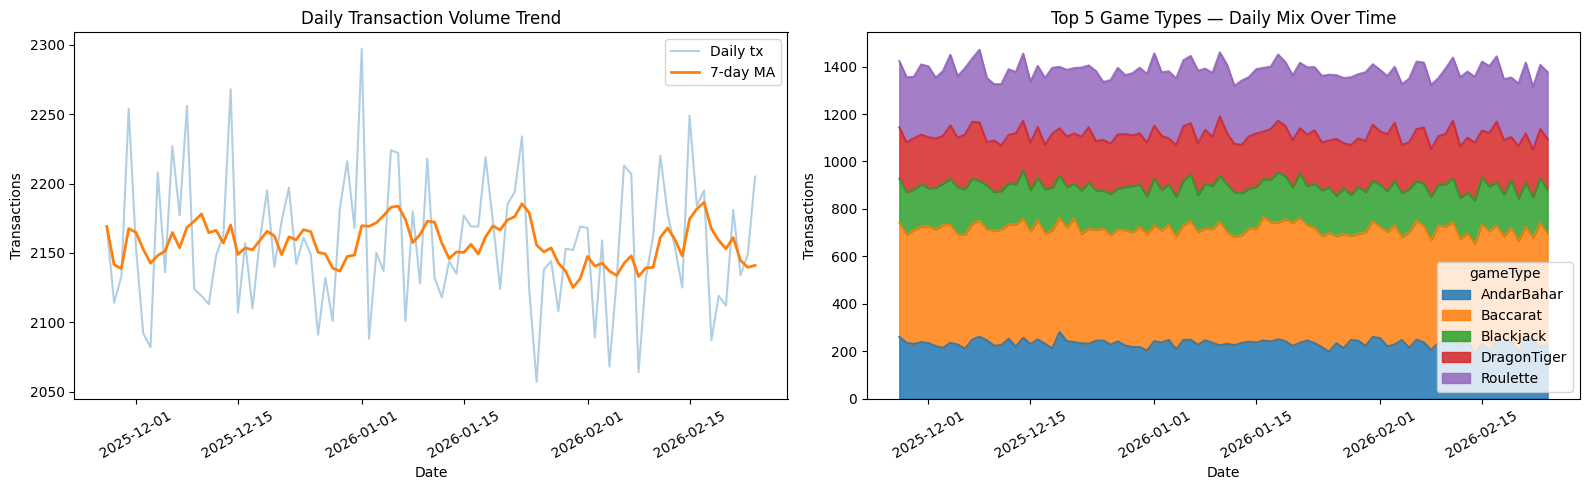

In [ ]:
# CELL 9.1 — Daily activity trend + 7-day moving average

plot_df = transactions_df.copy()
plot_df['date'] = plot_df['timestamp'].dt.date

daily_tx = plot_df.groupby('date').size().rename('tx_count').reset_index()
daily_tx['tx_ma7'] = daily_tx['tx_count'].rolling(7, min_periods=1).mean()

top_game_types = plot_df['gameType'].value_counts().head(5).index
stacked = (
    plot_df[plot_df['gameType'].isin(top_game_types)]
    .groupby(['date', 'gameType'])
    .size()
    .unstack(fill_value=0)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(daily_tx['date'], daily_tx['tx_count'], alpha=0.35, label='Daily tx')
axes[0].plot(daily_tx['date'], daily_tx['tx_ma7'], linewidth=2, label='7-day MA')
axes[0].set_title('Daily Transaction Volume Trend')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Transactions')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=30)

stacked.plot(kind='area', ax=axes[1], alpha=0.85)
axes[1].set_title('Top 5 Game Types — Daily Mix Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Transactions')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()  
plt.show()

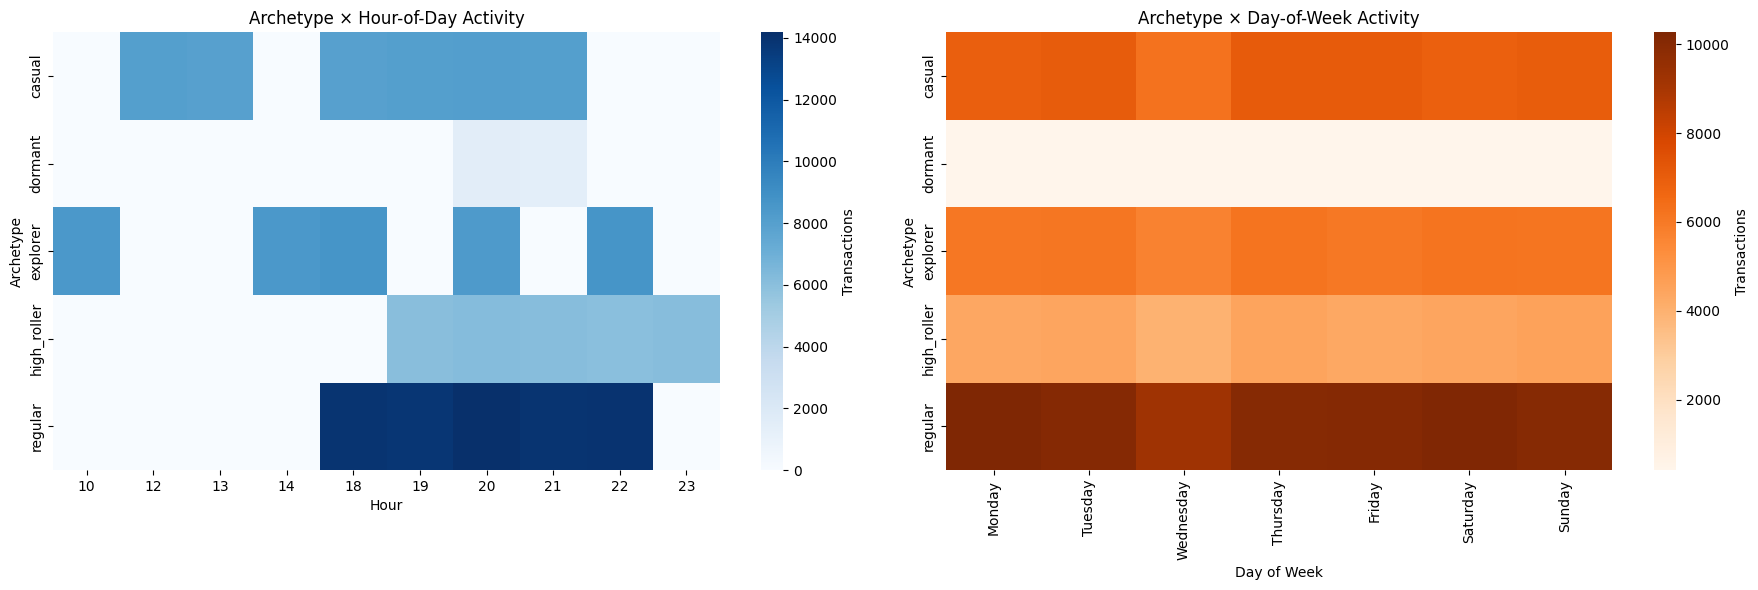

In [28]:
# CELL 9.2 — Segment behavior heatmaps (Archetype × Hour, Archetype × Day)

seg_df = transactions_df.merge(users_df[['userId', 'archetype']], on='userId', how='left')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

hour_heat = seg_df.pivot_table(
    index='archetype', columns='hourOfDay', values='userId', aggfunc='count', fill_value=0
)

day_heat = seg_df.pivot_table(
    index='archetype', columns='dayOfWeek', values='userId', aggfunc='count', fill_value=0
)

day_heat = day_heat.reindex(columns=[d for d in day_order if d in day_heat.columns])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(hour_heat, cmap='Blues', ax=axes[0], cbar_kws={'label': 'Transactions'})
axes[0].set_title('Archetype × Hour-of-Day Activity')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Archetype')

sns.heatmap(day_heat, cmap='Oranges', ax=axes[1], cbar_kws={'label': 'Transactions'})
axes[1].set_title('Archetype × Day-of-Week Activity')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Archetype')

plt.tight_layout()
plt.show()

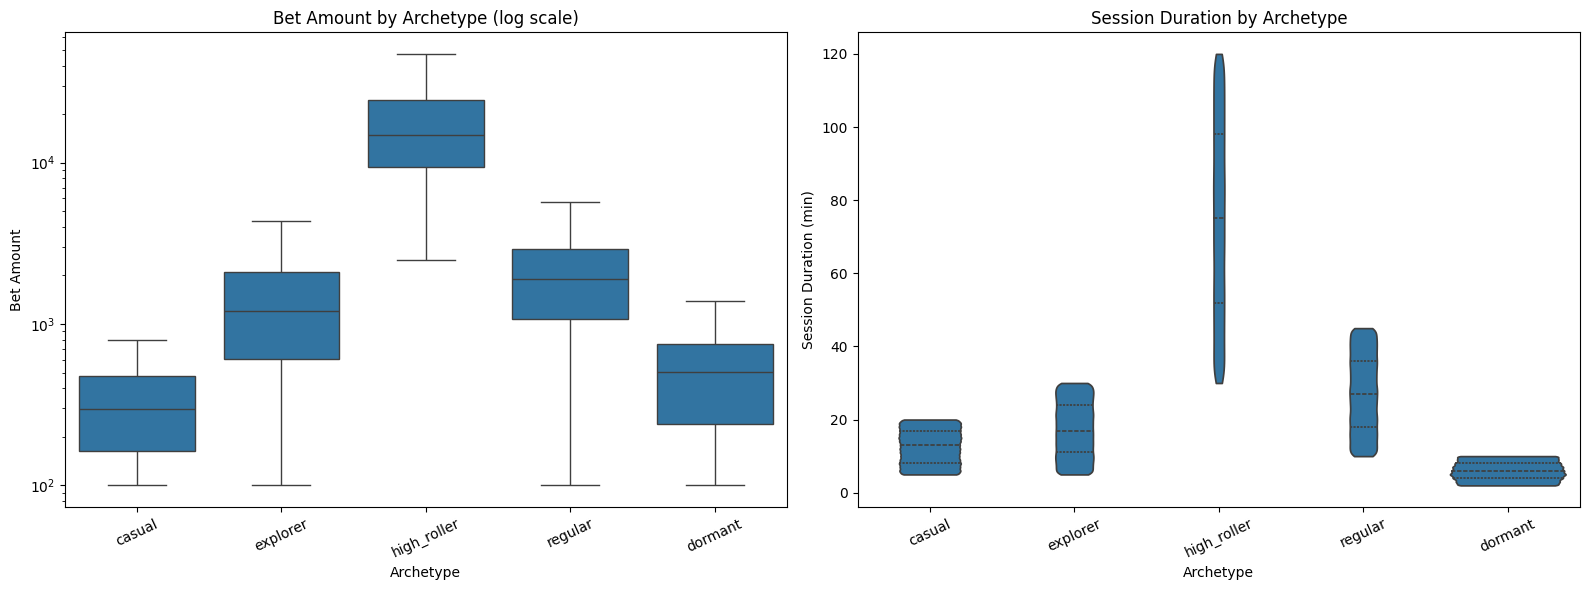

In [29]:
# CELL 9.3 — Bet size and session-duration distributions by archetype

seg_df = transactions_df.merge(users_df[['userId', 'archetype']], on='userId', how='left')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=seg_df,
    x='archetype',
    y='betAmount',
    showfliers=False,
    ax=axes[0]
)
axes[0].set_yscale('log')
axes[0].set_title('Bet Amount by Archetype (log scale)')
axes[0].set_xlabel('Archetype')
axes[0].set_ylabel('Bet Amount')
axes[0].tick_params(axis='x', rotation=25)

sns.violinplot(
    data=seg_df,
    x='archetype',
    y='sessionDuration',
    inner='quartile',
    cut=0,
    ax=axes[1]
)
axes[1].set_title('Session Duration by Archetype')
axes[1].set_xlabel('Archetype')
axes[1].set_ylabel('Session Duration (min)')
axes[1].tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.show()

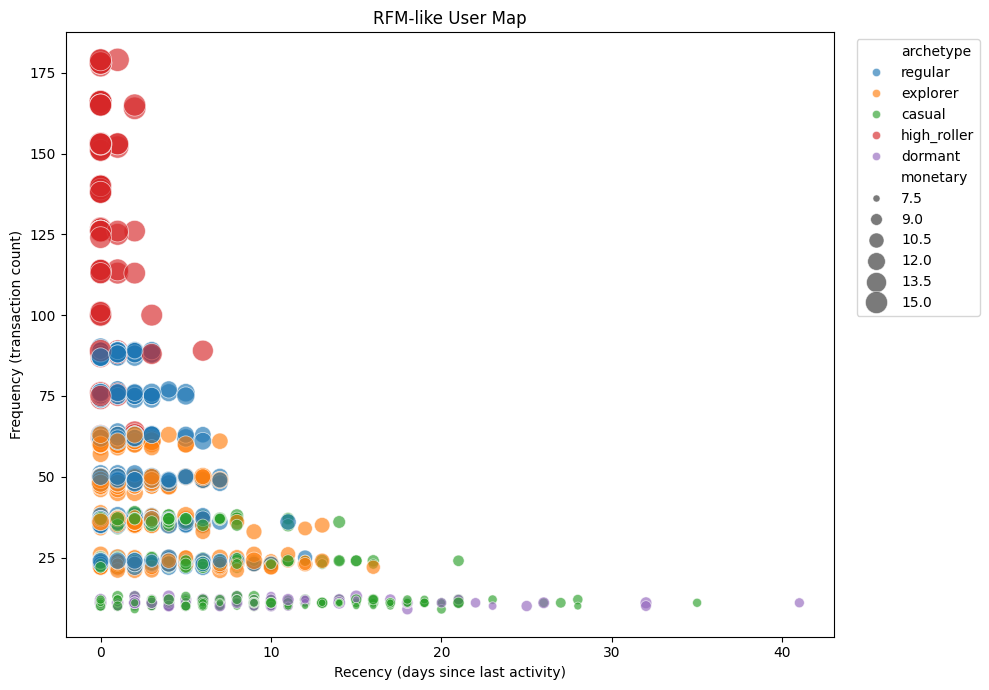

In [30]:
# CELL 9.4 — User-level RFM-style map (Recency vs Frequency, bubble=Monetary)

rfm = transactions_df.groupby('userId').agg(
    frequency=('betAmount', 'count'),
    monetary=('betAmount', 'sum'),
    last_ts=('timestamp', 'max')
).reset_index()
rfm['recency_days'] = (transactions_df['timestamp'].max() - rfm['last_ts']).dt.days
rfm = rfm.merge(users_df[['userId', 'archetype']], on='userId', how='left')

sample_n = min(2000, len(rfm))
rfm_plot = rfm.sample(sample_n, random_state=SEED)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=rfm_plot,
    x='recency_days',
    y='frequency',
    size=np.log1p(rfm_plot['monetary']),
    hue='archetype',
    alpha=0.65,
    sizes=(20, 280)
)
plt.title('RFM-like User Map')
plt.xlabel('Recency (days since last activity)')
plt.ylabel('Frequency (transaction count)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

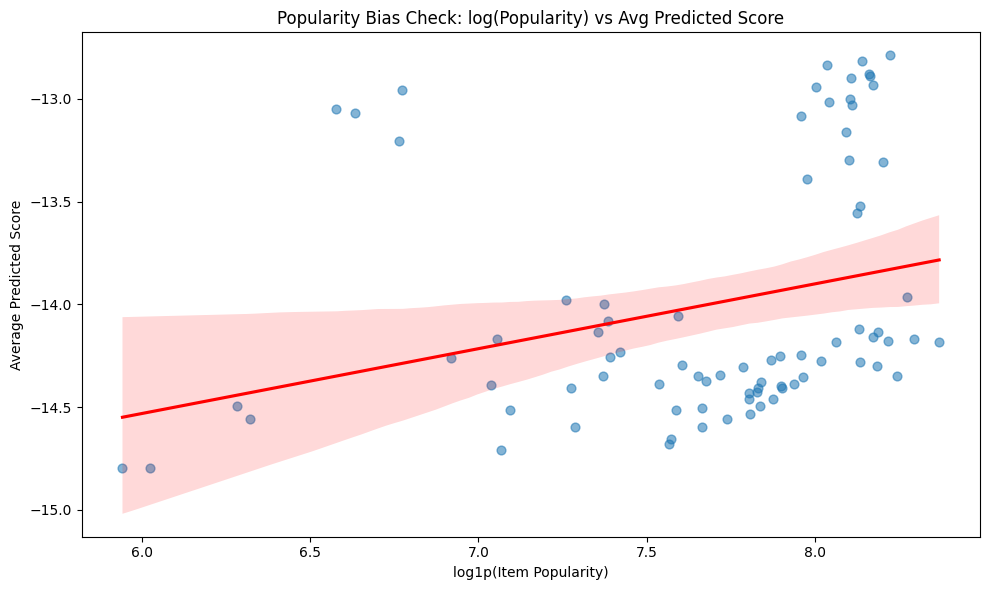

Spearman(popularity, avg_pred_score): 0.465


In [31]:
# CELL 9.5 — Item popularity vs model preference score (diagnose popularity bias)

if 'corr_df' not in globals():
    print('Run Cell 31 first to build `corr_df` and `pred_score`.')
else:
    pop_score = corr_df.groupby('gameId').agg(
        item_popularity=('total_plays', 'mean'),
        avg_pred_score=('pred_score', 'mean'),
        n_pairs=('pred_score', 'size')
    ).reset_index()

    plt.figure(figsize=(10, 6))
    sns.regplot(
        data=pop_score,
        x=np.log1p(pop_score['item_popularity']),
        y='avg_pred_score',
        scatter_kws={'alpha': 0.55, 's': 40},
        line_kws={'color': 'red'}
    )
    plt.title('Popularity Bias Check: log(Popularity) vs Avg Predicted Score')
    plt.xlabel('log1p(Item Popularity)')
    plt.ylabel('Average Predicted Score')
    plt.tight_layout()
    plt.show()

    corr_val = pop_score['item_popularity'].corr(pop_score['avg_pred_score'], method='spearman')
    print(f'Spearman(popularity, avg_pred_score): {corr_val:.3f}')

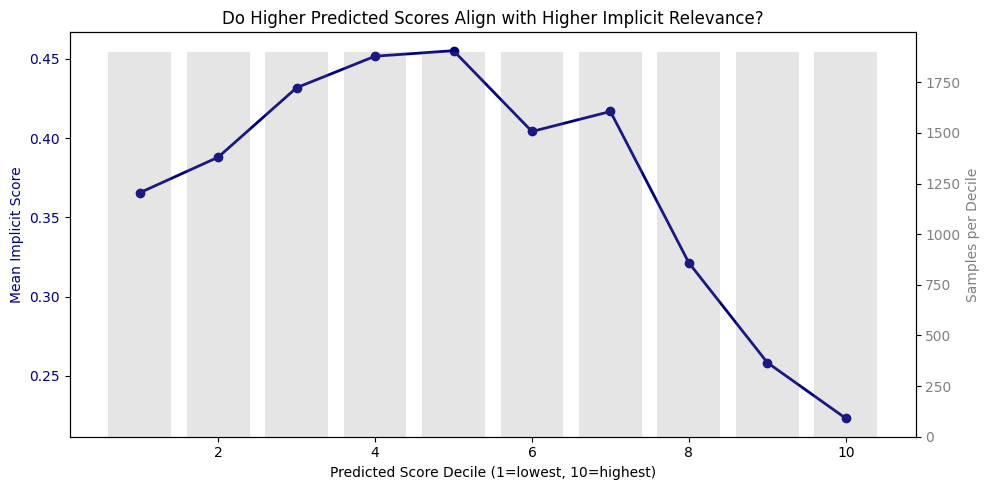

,score_decile,mean_pred_score,mean_implicit,samples
0,1,-15.769643,0.365565,1902
1,2,-14.891364,0.387999,1902
2,3,-14.484765,0.431837,1902
3,4,-14.275006,0.451703,1901
4,5,-14.089521,0.455164,1902
5,6,-13.842084,0.404202,1902
6,7,-13.469498,0.416829,1901
7,8,-12.981454,0.321350,1902
8,9,-12.190867,0.258427,1902
9,10,-11.008467,0.223251,1902


In [32]:
# CELL 9.6 — Predicted-score deciles vs implicit score (ranking quality sanity check)

if 'corr_df' not in globals():
    print('Run Cell 31 first to build `corr_df` and `pred_score`.')
else:
    dq = corr_df[['pred_score', 'implicit_score']].dropna().copy()
    dq['score_decile'] = pd.qcut(dq['pred_score'].rank(method='first'), 10, labels=False) + 1

    decile_view = dq.groupby('score_decile').agg(
        mean_pred_score=('pred_score', 'mean'),
        mean_implicit=('implicit_score', 'mean'),
        samples=('implicit_score', 'size')
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(decile_view['score_decile'], decile_view['mean_implicit'], marker='o', linewidth=2, color='navy')
    ax1.set_xlabel('Predicted Score Decile (1=lowest, 10=highest)')
    ax1.set_ylabel('Mean Implicit Score', color='navy')
    ax1.tick_params(axis='y', labelcolor='navy')
    ax1.set_title('Do Higher Predicted Scores Align with Higher Implicit Relevance?')

    ax2 = ax1.twinx()
    ax2.bar(decile_view['score_decile'], decile_view['samples'], alpha=0.2, color='gray')
    ax2.set_ylabel('Samples per Decile', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    plt.tight_layout()
    plt.show()

    display(decile_view)